In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision import datasets, models
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [ ]:
#importing images
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ryanphilip1805","key":"38c286eba0238fc807d74f9b66075c33"}'}

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

... resuming from 52428800 bytes (2845280387 bytes left) ...
100% 2.69G/2.70G [00:31<00:00, 155MB/s]
100% 2.70G/2.70G [00:32<00:00, 88.8MB/s]


In [ ]:
!unzip new-plant-diseases-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

In [ ]:
import os
import torch
import torch.utils.data as data
from torchvision.datasets.folder import default_loader

In [ ]:
#To split the data into a format the SVM model can use, this custom dataset loader was used
class CustomDataset(data.Dataset):
    def __init__(self, root_folder, transform=None):
        self.root = root_folder
        self.classes, self.class_to_idx = self._find_classes(self.root)
        self.samples = self._make_dataset(self.root, self.class_to_idx)
        self.loader = default_loader
        self.transform = transform

    def _find_classes(self, dir):
        classes = [d.name for d in os.scandir(dir) if d.is_dir()] #the data from kaggle is already split into the folders and the classes are stored in its name
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)} #assigning numeric index to the model
        return classes, class_to_idx

    def _make_dataset(self, dir, class_to_idx):
        samples = []
        for target_class in sorted(class_to_idx.keys()):
            class_dir = os.path.join(dir, target_class)
            if not os.path.isdir(class_dir):
                continue
            for root, _, fnames in sorted(os.walk(class_dir)):
                for fname in fnames:
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target_class])
                    samples.append(item)
        return samples

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
          img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.samples)

In [ ]:
root_folder = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
data_transform = transforms.Compose([transforms.ToTensor()])
train_dataset = CustomDataset(root_folder, transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

root_folder = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
data_transform = transforms.Compose([transforms.ToTensor()])
valid_dataset = CustomDataset(root_folder, transform=data_transform)


valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=True)


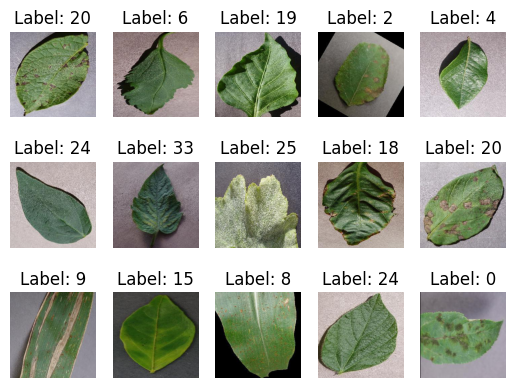

In [ ]:
#printing sample images
k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])

    # Get the corresponding label
    label = labels[0]

    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)
    plt.title(f"Label: {label}")  # Print the label as the title

    k += 1
    if k > 14:
        break

plt.show()

In [ ]:
# Defining the parameters grid for GridSearchCV
param_grid={'C':[0.1, 100],
            'gamma':[0.0001, 1],
            'kernel':['rbf', 'poly']}


# Creating a support vector classifier
svc=svm.SVC(probability=True)

# Creating a model using GridSearchCV with the parameters grid
model = GridSearchCV(svc,param_grid)

In [ ]:
#splitting the data into np arrays for the SVC model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = []
y_train = []

for images, labels in train_loader:
    images = images.to(device)  # Move images to GPU
    labels = labels.to(device)  # Move labels to GPU
    x_train.append(images[0].clone().detach())  # Append a copy of the image to the list
    y_train.append(labels[0].clone().detach())  # Append a copy of the label to the list



In [ ]:
# Convert the lists to PyTorch tensors
x_train_tensor = torch.stack(x_train)
y_train_tensor = torch.tensor(y_train)

# Move the tensors to the CPU
x_train_tensor_cpu = x_train_tensor.cpu()
y_train_tensor_cpu = y_train_tensor.cpu()

# Convert the CPU tensors to NumPy arrays
x_train_numpy = x_train_tensor_cpu.numpy()
y_train_numpy = y_train_tensor_cpu.numpy()

In [ ]:
x_train_numpy.shape
#need to flatten x_train_numpy array as SVM requires dim <= 2
x_train_flattened = x_train_numpy.reshape(x_train_numpy.shape[0], -1)

In [ ]:
model.fit(x_train_flattened, y_train_numpy)

In [ ]:
# Get labels and images for valdiation data
x_val = []
y_val = []

for images, labels in valid_loader:
    images = images.to(device)  # Move images to GPU
    labels = labels.to(device)  # Move labels to GPU
    x_val.append(images[0].clone().detach())  # Append a copy of the image to the list
    y_val.append(labels[0].clone().detach())  # Append a copy of the label to the list

In [ ]:
# Convert the lists to PyTorch tensors
x_val_tensor = torch.stack(x_val)
y_val_tensor = torch.tensor(y_val)

# Move the tensors to the CPU
x_val_tensor_cpu = x_val_tensor.cpu()
y_val_tensor_cpu = y_val_tensor.cpu()

# Convert the CPU tensors to NumPy arrays
x_val_numpy = x_val_tensor_cpu.numpy()
y_val_numpy = y_val_tensor_cpu.numpy()

#need to flatten x_val_numpy array as SVM requires dim <= 2
x_val_flattened = x_val_numpy.reshape(x_val_numpy.shape[0], -1)

In [ ]:
# Now we need to pass validaiton data to SVM model
# and plot the training and validation loss and error curves

# Calculate training error
y_train_pred = model.predict(x_train_flattened)
train_error = 1 - accuracy_score(y_train_numpy, y_train_pred)

# Calculate validation error
y_val_pred = model.predict(x_val_flattened)
val_error = 1 - accuracy_score(y_val_numpy, y_val_pred)

In [ ]:
print(train_errors, val_errors)

[0.0] [0.572463768115942]


This training error, shows that the model was overfitted. The accuracy is around 43% which is better than random chance as we have 38 classes, so each chance has approximately 2.6% chance of being predicted.

In [ ]:
# Testing the model using the testing data
y_pred = model.predict(x_test)

y_pred = y_pred.cpu()
y_test = y_test.cpu()

# Calculating the accuracy of the model
accuracy = accuracy_score(y_pred, y_test)

# Print the accuracy of the model
print(f"The model is {accuracy*100}% accurate")

Initial Training with 5 classes code.
Note: to test how the model will perform on 5 classes that were manually chosen due to their obvious visual differences between the plant leaves themselves.

In [ ]:
model.fit(x_train_flattened, y_train_numpy)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 100], 'gamma': [0.0001, 1],
                         'kernel': ['rbf', 'poly']})

In [ ]:
#
class CustomDataset(data.Dataset):
    def __init__(self, root_folder, transform=None):
        self.root = root_folder
        self.classes, self.class_to_idx = self._find_classes(self.root)
        self.classes_of_interest = [
            "Cherry_(including_sour)___Powdery_mildew",
            "Apple___Apple_scab",
            "Corn_(maize)___Common_rust",
            "Grape___Black_rot",
            "Potato___Early_blight"
        ]
        self.samples = self._make_dataset(self.root, self.class_to_idx, self.classes_of_interest)
        self.loader = default_loader
        self.transform = transform

    def _find_classes(self, dir):
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def _make_dataset(self, dir, class_to_idx, classes_of_interest):
        samples = []
        for target_class in sorted(class_to_idx.keys()):
            if target_class in classes_of_interest:
                class_dir = os.path.join(dir, target_class)
                if not os.path.isdir(class_dir):
                    continue
                for root, _, fnames in sorted(os.walk(class_dir)):
                    for fname in fnames:
                        path = os.path.join(root, fname)
                        item = (path, class_to_idx[target_class])
                        samples.append(item)
        return samples

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.samples)

In [ ]:
root_folder = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
data_transform = transforms.Compose([transforms.ToTensor()])
train_dataset = CustomDataset(root_folder, transform=data_transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

root_folder = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
data_transform = transforms.Compose([transforms.ToTensor()])
valid_dataset = CustomDataset(root_folder, transform=data_transform)


valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)

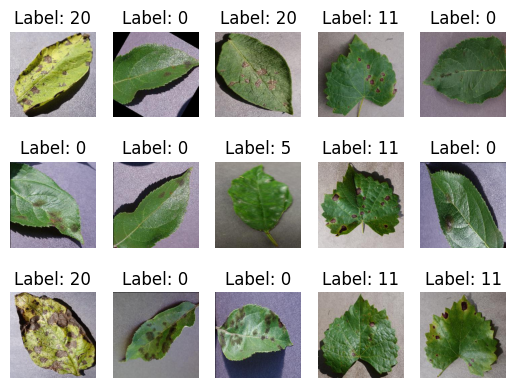

In [ ]:
k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])

    # Get the corresponding label
    label = labels[0]

    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)
    plt.title(f"Label: {label}")  # Print the label as the title

    k += 1
    if k > 14:
        break

plt.show()

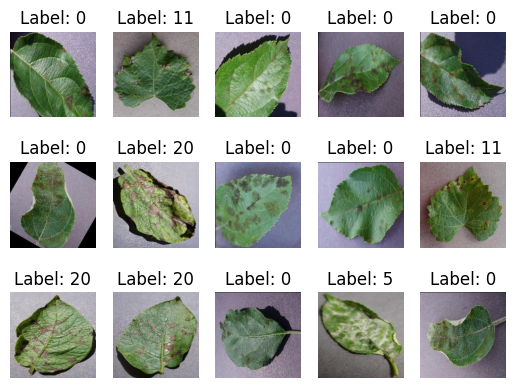

In [ ]:
k = 0
for images, labels in valid_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])

    # Get the corresponding label
    label = labels[0]

    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)
    plt.title(f"Label: {label}")  # Print the label as the title

    k += 1
    if k > 14:
        break

plt.show()

In [ ]:
# Defining the parameters grid for GridSearchCV
param_grid={'C':[0.1, 100],
            'gamma':[0.0001, 1],
            'kernel':['rbf', 'poly']}


# Creating a support vector classifier
svc=svm.SVC(probability=True)

# Creating a model using GridSearchCV with the parameters grid
model = GridSearchCV(svc,param_grid)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = []
y_train = []

for images, labels in train_loader:
    images = images.to(device)  # Move images to GPU
    labels = labels.to(device)  # Move labels to GPU
    x_train.append(images[0].clone().detach())  # Append a copy of the image to the list
    y_train.append(labels[0].clone().detach())  # Append a copy of the label to the list

In [ ]:
# Convert the lists to PyTorch tensors
x_train_tensor = torch.stack(x_train)
y_train_tensor = torch.tensor(y_train)

# Move the tensors to the CPU
x_train_tensor_cpu = x_train_tensor.cpu()
y_train_tensor_cpu = y_train_tensor.cpu()

# Convert the CPU tensors to NumPy arrays
x_train_numpy = x_train_tensor_cpu.numpy()
y_train_numpy = y_train_tensor_cpu.numpy()

In [ ]:
x_train_numpy.shape

#need to flatten x_train_numpy array as SVM requires dim <= 2
x_train_flattened = x_train_numpy.reshape(x_train_numpy.shape[0], -1)

In [ ]:
model.fit(x_train_flattened, y_train_numpy)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 100], 'gamma': [0.0001, 1],
                         'kernel': ['rbf', 'poly']})

In [ ]:
# Get labels and images for valdiation data
x_val = []
y_val = []

for images, labels in valid_loader:
    images = images.to(device)  # Move images to GPU
    labels = labels.to(device)  # Move labels to GPU
    x_val.append(images[0].clone().detach())  # Append a copy of the image to the list
    y_val.append(labels[0].clone().detach())  # Append a copy of the label to the list

In [ ]:
# Convert the lists to PyTorch tensors
x_val_tensor = torch.stack(x_val)
y_val_tensor = torch.tensor(y_val)

# Move the tensors to the CPU
x_val_tensor_cpu = x_val_tensor.cpu()
y_val_tensor_cpu = y_val_tensor.cpu()

# Convert the CPU tensors to NumPy arrays
x_val_numpy = x_val_tensor_cpu.numpy()
y_val_numpy = y_val_tensor_cpu.numpy()

#need to flatten x_val_numpy array as SVM requires dim <= 2
x_val_flattened = x_val_numpy.reshape(x_val_numpy.shape[0], -1)

In [ ]:
# Now we need to pass validaiton data to SVM model
# and plot the training and validation loss and error curves

# Calculate training error
y_train_pred = model.predict(x_train_flattened)
train_error = 1 - accuracy_score(y_train_numpy, y_train_pred)

# Calculate validation error
y_val_pred = model.predict(x_val_flattened)
val_error = 1 - accuracy_score(y_val_numpy, y_val_pred)

In [ ]:
print(train_error, val_error)

0.0 0.10169491525423724
